# Initializer

In [1]:
import numpy as np
import os
import display
import random
from PIL import Image
import darknet
import _pickle as cPickle
import time
import torch
import datetime
import argparse
import torch.nn as nn
import TFBoard
import sys
import util
import copy
import cv2
import math
import ctypes
from itertools import chain
from torch.nn.parameter import Parameter
import torch.nn.init as init
import torch.nn.functional as F
import multiprocessing
def in_notebook():
    return 'ipykernel' in sys.modules
if in_notebook():
    %matplotlib inline
    
data_dataset=None

c:\users\ainl\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## argparse

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=64, help='size of the batches')
parser.add_argument('--lr', type=float, default=0.0002, help='adam: learning rate')
parser.add_argument('--lr_update', default=False, action='store_true', help='lupdate learning rate')
parser.add_argument('--b1', type=float, default=0.5, help='adam: decay of first order momentum of gradient')
parser.add_argument('--b2', type=float, default=0.999, help='adam: decay of first order momentum of gradient')
parser.add_argument('--n_cpu', type=int, default=16, help='number of cpu threads to use during batch generation')
parser.add_argument('--img_size', type=int, default=192, help='image size')
parser.add_argument('--vgg_depth', type=int, default=10, help='image size')
parser.add_argument('--load', default=False, action='store_true', help='load from saved checkpoint')
parser.add_argument('--no_save', default=False, action='store_true', help='load data from saved cache')
parser.add_argument('--mode', default='traina', help='delimited list input', type=str)
parser.add_argument('--target', default='id', help='delimited list input', type=str)

if in_notebook():
    print("parsing is passed. running on notbook")
    parser.add_argument('strings', metavar='STRING', nargs='*', help='String for searching',)
    parser.add_argument('-f','--file',help='Path for input file. First line should contain number of lines to search in')
    opt = parser.parse_args()
else:
    opt = parser.parse_args()
print("parsed option:", opt)

opt.cuda = True if torch.cuda.is_available() else False
if opt.cuda:
    device_cuda = torch.device('cuda:0')
Tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor

parsing is passed. running on notbook
parsed option: Namespace(b1=0.5, b2=0.999, batch_size=64, file='C:\\Users\\AinL\\AppData\\Roaming\\jupyter\\runtime\\kernel-3659c0c4-96c5-44f1-a4b8-7cbf3fd50b36.json', img_size=192, load=False, lr=0.0002, lr_update=False, mode='traina', n_cpu=16, no_save=False, strings=[], target='id', vgg_depth=10)


## utilfunc

In [3]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

def calc_code_dim(opt):
    return (5 + opt.text_dim + opt.style_dim) * opt.bbox_count + opt.latent_dim

def getTimeStamp():
    timestemp = time.strftime(R"%m-%d_%H-%M-%S", time.localtime())
    return timestemp

def parseFloatList(string):
    spl = string.split()
    ret = []
    for i in spl:
        ret.append(float(i))
    return ret

def imgproc(nd):
    t = Tensor(nd)
    t = t.permute(0, 3, 1, 2)
    t = (t.float() - 127.5)/127.5
    return t

class Logger():
    def __init__(self, logdir='./temp', outputLimit=32):
        self.logdir = logdir
        self.stack = 0
        self.outputLimit = outputLimit
        self.startTime = datetime.datetime.now()
        self.tfboard = None
    
    def print(self, msg, flush=True):
        if self.stack > self.outputLimit:
            display.clear()
            self.stack = 0
        if flush:
            self.stack += 1
        timeMsg = str(datetime.datetime.now()-self.startTime)
        print("[{}] {}".format(timeMsg, msg))
    
    def log_image(self, dic, global_step=None):
        if self.tfboard is None:
            self.tfboard = TFBoard.Tensorboard(self.logdir)
            self.print('tfboard inited: ' + self.logdir)
        for k in dic:
            self.tfboard.log_image(k, dic[k], global_step)
        
    def log(self, scalarDict, global_step=None):
        if self.tfboard is None:
            self.tfboard = TFBoard.Tensorboard(self.logdir)
            self.print('tfboard inited: ' + self.logdir)
        output = ""
        for i, k in enumerate(sorted(scalarDict.keys())):
            v = scalarDict[k]
            if isinstance(v, torch.Tensor):
                v = v.detach().cpu().numpy()
            if global_step is not None:
                self.tfboard.log_scalar(k, v, global_step, flush=False)
            t = k+" : "+str(v)
            if i!=0:
                t+=', \n'
            output = t+output
        if global_step is not None:
            output = "(" + str(global_step) + " steps) " + output
        if self.tfboard is not None:
            self.tfboard.flush()
        self.print(output)

# Dataset

In [4]:
class Cat:
    def __init__(self, path=None, string=None):
        self.path = path
        self.landmarks = []
        self.prob=self.ax=self.ay=self.aw=self.ah=0
        self.prob=1
        self.cache = None
        self.cacheAug = None
        self.cacheAugLandmark = None
        self.cacheAugFace = None
        self.cacheAugLife = 0
        self.useCacheAug = True
        if not string is None:
            self.parseString(string)
    
    def parseString(self, string):
        #decode .cat
        path = self.path
        dat = parseFloatList(string)
        if dat[0] != 9:
            raise Exception('unexpected points')
        minX = minY = 10000
        maxX = maxY = -1
        for i in range(int(dat[0])):
            x = dat[i*2+1]
            y = dat[i*2+2]
            minX = min(minX, x)
            minY = min(minY, y)
            maxX = max(maxX, x)
            maxY = max(maxY, y)
            self.landmarks.append([x,y])
        cx = (minX + maxX) / 2
        cy = (minY + maxY) / 2
        im = Image.open(path)
        self.width, self.height = im.size
        w = int(min(max(maxX-minX, maxY-minY) * 1.5, self.width, self.height))
        cx = min(self.width - w/2, max(w/2, cx))
        cy = min(self.height - w/2, max(w/2, cy))
        self.ax = int(cx - w/2)
        self.ay = int(cy - w/2)
        self.cx = cx
        self.cy = cy
        self.aw = int(w)
        self.ah = int(w)
        self.rx = self.cx / self.width
        self.ry = self.cy / self.height
        self.rw = self.aw / self.width
        self.rh = self.ah / self.height
    
    def perspective_roi(self, img):
        def pointAvg(points, idxs):
            point = [0,0]
            for i in idxs:
                point[0]+=points[i][0]
                point[1]+=points[i][1]
            point =[point[0]/len(idxs), point[1]/len(idxs)]
            return point
        marks = self.landmarks
        lear = pointAvg(marks, (3,4,5))
        rear = pointAvg(marks, (6,7,8))
        lchick = pointAvg(marks, (0,2))
        rchick = pointAvg(marks, (1,2))
        # 좌표점은 좌상->좌하->우상->우하
        pts1 = np.float32([lear, lchick, rear, rchick])
        # 좌표의 이동점
        pts2 = np.float32([[0.15,0.2],[0.375+0.025,0.65],[0.85,0.2],[0.625-0.025,0.65]])
        pts2 *= [[opt.img_size, opt.img_size]]

        M = cv2.getPerspectiveTransform(pts1, pts2)
        dst = cv2.warpPerspective(img, M, (opt.img_size, opt.img_size))
        return dst
    
    def roi(self, im):
        return im[self.ay:self.ay+self.ah, self.ax:self.ax+self.aw]
    
    def imread(self):
        if self.cache is None:
            self.cache = cv2.imread(self.path)
        shared_mat = self.cache
        im = shared_mat
        return im
    
    def draw(self, img, thickness=2):
        color = (0,int(self.prob*255),int((1-self.prob)*255))
        for i in range(9):
            pt = (int(self.landmarks[i][0]),int(self.landmarks[i][1]))
            cv2.circle(img, pt, thickness, color, -1)
            cv2.putText(img, str(i), pt, cv2.FONT_HERSHEY_SIMPLEX, 1, color, thickness)
        cv2.rectangle(img, (int(self.ax), int(self.ay)), (int(self.ax+self.aw), int(self.ay+self.ah)), color, thickness)
        cv2.putText(img, str(int(self.prob*100)), (int(self.ax), int(self.ay)), cv2.FONT_HERSHEY_SIMPLEX, 1, color, thickness, cv2.LINE_AA)
        return img
    
    def clone(self):
        rect = self
        cache = rect.cache
        cacheAug = rect.cacheAug
        rect.cache = rect.cacheAug = None
        face = copy.deepcopy(rect)
        rect.cache = cache
        rect.cacheAug = cacheAug
        return face

class Dataset:
    def __init__(self, path='F:\\Library\\kitty\\cat-dataset\\cats'):
        self.path = path
        self.faces = []
        self.load()
    
    def load(self):
        print('searching')
        for dirpath, dnames, fnames in os.walk(self.path):
            for f in fnames:
                if f.endswith(".jpg"):
                    path = os.path.join(dirpath, f)
                    pathCat = path.replace('.jpg', '.jpg.cat')
                    if os.path.exists(path) and os.path.exists(pathCat):
                        with open(pathCat) as f:
                            lines = f.readlines()
                        self.faces.append(Cat(path, lines[0]))
        print(len(self.faces), 'searched')
    
    def batch(self, count):
        ret = []
        for _ in range(count):
            i = random.randint(0, len(self.faces)-1)
            ret.append(self.faces[i])
        return ret

class YoloDataset:
    def __init__(self, dataset):
        self.dataset = dataset
    
    def convert(self):
        print('converting')
        train = []
        valid = []
        for face in self.dataset.faces:
            path = face.path
            pathTxt = path.replace('.jpg', '.txt')
            
            if os.path.exists(pathTxt):
                os.remove(pathTxt)
            
            with open(pathTxt, mode='w') as f:
                text = "0 {} {} {} {}\n".format(face.rx, face.ry, face.rw, face.rh)
                f.write(text)
            
            if random.random() > 0.05:
                train.append(face.path + '\n')
            else:
                valid.append(face.path + '\n')
        
        if os.path.exists("train.txt"):
            os.remove("train.txt")
        if os.path.exists("valid.txt"):
            os.remove("valid.txt")
        
        with open("train.txt", "w") as f:
            f.writelines(train)
        with open("valid.txt", "w") as f:
            f.writelines(valid)
        print('finished')

class ImgProc:
    def __init__(self, imgsize):
        self.img_size = imgsize

    def procSingle(self, rect, hsv=True, hsv_h=60, hsv_s=60, hsv_b=128, hsv_v=0.4, hsv_rate=0.5):
        rect.cacheAugLife -= 1
        if rect.cacheAug is None or rect.cacheAugLife < 0 or not rect.useCacheAug:
#                 print('c', end='')
            cache = rect.cache
            cacheAug = rect.cacheAug
            rect.cache = rect.cacheAug = None
            face = copy.deepcopy(rect)
            rect.cache = cache
            rect.cacheAug = cacheAug
            #roi box rand
            ##size rand
            if random.random() > 0.1:
                rmin = 0.65
                rmax = 3
                face.aw = int(min(face.aw * (rmin+random.random()*(rmax-rmin)), face.width, face.height))
                face.ah = face.aw
                face.cx = int(np.clip(face.cx, face.aw/2+1, face.width-face.aw/2-2))
                face.cy = int(np.clip(face.cy, face.ah/2+1, face.height-face.ah/2-2))
                face.ax = int(max(0,face.cx-face.aw/2))
                face.ay = int(max(0, face.cy-face.ah/2))
            ##pose shift
            if random.random() > 0.1:
                r = 0.25
                shiftx = face.aw * (r * random.random()-r/2)
                shifty = face.ah * (r * random.random()-r/2)
                face.ax = int(np.clip(face.ax+shiftx, 0, face.width - face.aw))
                face.ay = int(np.clip(face.ay+shifty, 0, face.height - face.ah))
            ##resize roi
            if random.random() > 0.3:
                h, w = face.ah, face.aw
                r = 1 - 0.5 * random.random()
                c = random.random()
                if c > 0.5:
                    h = int(h*r)
                    face.ay = int(face.ay + (face.ah-h)/2)
                    face.ah = h
                else:
                    w = int(w*r)
                    face.ax = int(face.ax + (face.aw-w)/2)
                    face.aw = w
            #crop
#             print(face.cx, face.cy, face.ax, face.ay, face.aw, face.ah, face.width, face.height)
            im = cv2.resize(face.roi(rect.imread()), dsize=(self.img_size, self.img_size))
            l = face.landmarks
            for i in range(9):
                l[i][0] = (l[i][0]-face.ax)/face.aw
                l[i][1] = (l[i][1]-face.ay)/face.ah
            #img rand
            ##hflip
            if random.random() > 20.5:
                im = cv2.flip(im, 1)
                for i in range(9):
                    l[i][0] = 1-l[i][0]
            ##vflip HJ:FLIP IS NOT GOOD FOR LEFT RIGHT DEPENDING DATASET
            if random.random() > 20.5:
                im = cv2.flip(im, 0)
                for i in range(9):
                    l[i][1] = 1-l[i][1]
            ##rotation
            if random.random() > 0.3:
                angle = 360 * random.random()
                M = cv2.getRotationMatrix2D((im.shape[1]/2, im.shape[0]/2), angle, 1)
                im = cv2.warpAffine(im, M, (im.shape[1], im.shape[0]))
                for i in range(9):
                    rad = -angle * 3.1415 / 180
                    x,y=l[i]
                    x-=0.5
                    y-=0.5
                    x_=x*math.cos(rad)-y*math.sin(rad)
                    y_=x*math.sin(rad)+y*math.cos(rad)
                    x=x_+0.5
                    y=y_+0.5
                    l[i][0]=x
                    l[i][1]=y
            ##HSV rand
            if random.random() > 1-hsv_rate and hsv:
                hr=hsv_h/2-hsv_h*random.random()
                sr=hsv_s/2-hsv_s*random.random()
                vr=1+hsv_v/2-hsv_v*random.random()
                br=hsv_b/2-hsv_b*random.random()
                im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
                im[:,:,:] += np.asarray([[[hr, 0, 0]]], dtype=np.uint8)
                im = im.astype(np.float)
                im[:,:,:] += np.asarray([[[0, sr, br]]], dtype=np.float)
                im[:,:,2] *= vr
                im = np.clip(im, 0, 255)
                im = im.astype(np.uint8)
                im = cv2.cvtColor(im, cv2.COLOR_HSV2BGR)
            ##Bilateral Filtering
            if random.random() > 0.7:
                im = cv2.bilateralFilter(im,9,75,75)
            ##noise
            if random.random() > 0.5:
                im = im.astype(np.int)
                noise = np.random.randint(-32, 32, size=im.shape, dtype='int')
                im += noise
                im = np.clip(im, 0, 255)
                im = im.astype(np.uint8)
            ##median
            if random.random() > 0.7:
                i = random.randint(0,2)
                im = cv2.medianBlur(im, 1+i*2)
            rect.cacheAug = im
            rect.cacheAugLandmark = l
            rect.cacheAugFace = face
            rect.cacheAugLife = random.randint(0, 16)

        return rect.cacheAug, rect.cacheAugLandmark, rect.cacheAugFace

    def procChunch(self,rects):
        ret=[]
#             print(rects, len(rects))
        imgs = np.zeros((len(rects), self.img_size, self.img_size, 3), dtype=float)
        landmarks = np.zeros((len(rects), 18), dtype=float)
        for idx, f in enumerate(rects):
            im, l, r = self.procSingle(f)
            if len(l) != 9:
                raise Exception()
            for i, p in enumerate(l):
                landmarks[idx, 2*i] = p[0]
                landmarks[idx, 2*i+1] = p[1]
            imgs[idx,:,:,:] = im
            ret.append(r)
        return imgs, landmarks, ret

    def __call__(self, rects):
        return self.procChunch(rects)
#             return self.procSingle(rects)
class LandmarkDataset:
    def __init__(self, dataset, img_size=128):
        self.dataset = dataset
        self.img_size = img_size
        self.mt = True
        self.par = None
    
    def batch(self, count):
        faces = self.dataset.batch(count)
        
        proc = ImgProc(self.img_size)
        if self.mt:
            #init
            if self.par is None:
                print("prepare parallel")
                for idx, f in enumerate(self.dataset.faces):
                    if opt.mode == 'train' and False:
                        f.imread()
                    if idx%500 == 0:
                        print("load cache...", idx, '/', len(self.dataset.faces))
                self.par = util.Parallel()
            #map
            mappedFaces = [[] for _ in range(self.par.workerCount)]
            for i, f in enumerate(faces):
#                 print(i%self.par.workerCount)
                mappedFaces[i % self.par.workerCount].append(f)
#             mapped = self.par.map(proc, faces)
#             imgs = np.zeros((count, self.img_size, self.img_size, 3), dtype=float)
#             landmarks = np.zeros((count, 18), dtype=float)
#             for idx in range(len(faces)):
#                 chunch = mapped[idx]
#                 im = chunch[0]
#                 l = chunch[1]
#                 if len(l) != 9:
#                     raise Exception()
#                 for i, p in enumerate(l):
#                     landmarks[idx, 2*i] = p[0]
#                     landmarks[idx, 2*i+1] = p[1]
#                 imgs[idx,:,:,:] = im
            
            mapped = self.par.map(proc, mappedFaces)
            t = time.time()
            imgs = []
            landmarks = []
            for m in mapped:
                imgs.append(m[0])
                landmarks.append(m[1])
#                 print(m[0].shape)
            imgs = np.concatenate(imgs, axis=0)
            landmarks = np.concatenate(landmarks, axis=0)
            if opt.mode !='train':
                print(time.time()-t)
#             print(self.par.workerCount, imgs.shape, landmarks.shape)
        else:
            imgs = np.zeros((count, self.img_size, self.img_size, 3), dtype=float)
            landmarks = np.zeros((count, 18), dtype=float)
            for idx in range(len(faces)):
                face = faces[idx]
                chunch = proc.procSingle(face)
                face = chunch[2]
                im = chunch[0]
                l = chunch[1]
                if len(l) != 9:
                    raise Exception()
                for i, p in enumerate(l):
                    landmarks[idx, 2*i] = p[0]
                    landmarks[idx, 2*i+1] = p[1]
                imgs[idx,:,:,:] = im
        return imgs, landmarks

## runtime

prepare parallel
load cache... 0 / 9997
load cache... 500 / 9997
load cache... 1000 / 9997
load cache... 1500 / 9997
load cache... 2000 / 9997
load cache... 2500 / 9997
load cache... 3000 / 9997
load cache... 3500 / 9997
load cache... 4000 / 9997
load cache... 4500 / 9997
load cache... 5000 / 9997
load cache... 5500 / 9997
load cache... 6000 / 9997
load cache... 6500 / 9997
load cache... 7000 / 9997
load cache... 7500 / 9997
load cache... 8000 / 9997
load cache... 8500 / 9997
load cache... 9000 / 9997
load cache... 9500 / 9997
0.01601266860961914


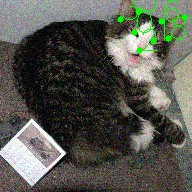

In [5]:
def dataset_main():
    print('hello')
    data = Dataset()
    batch = data.batch(16)
    data_landmark = LandmarkDataset(data)
    data_landmark.mt = True
    batch_landmark = data_landmark.batch(16)
    for idx, frame in enumerate(batch):
        im = frame.imread()
        for i in range(9):
            cv2.circle(im,(int(frame.landmarks[i][0]),int(frame.landmarks[i][1])), 3, (0,255,0), -1)
        cv2.rectangle(im, (int(frame.ax), int(frame.ay)), (int(frame.ax+frame.aw), int(frame.ay+frame.ah)), (255,0,255), 3)
        display.imshow(im)
        roi = im[frame.ay:frame.ay+frame.ah, frame.ax:frame.ax+frame.aw]
        display.imshow(roi)
        display.imshow(batch_landmark[0][idx])

def dataset_test():
    data = LandmarkDataset(data_dataset, img_size=opt.img_size)
    data.mt = True
    display.clear()
    for i in range(1):
        img, mark = data.batch(opt.batch_size)
        img = img[0]
        for p in range(9):
            pt = (int(mark[0][2*p]*data.img_size), int(mark[0][2*p+1]*data.img_size))
            cv2.circle(img, pt, 3, (0,255,0), -1)
            cv2.putText(img, str(p), pt, cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 1)
        display.imshow(img)
        if i>0 and i%10==0:
            display.clear()

def dataset_bench():
    print('hello')
    data = Dataset()
    batch = data.batch(opt.batch_size)
    data_landmark = LandmarkDataset(data)
    data_landmark.mt = True
    i = 0
    count = 0
    while True:
        t = time.time()
        batch_landmark = data_landmark.batch(opt.batch_size)
        t = time.time() - t
        count += opt.batch_size
        print(opt.batch_size/t , "img/s", count, "readed")
        print(batch_landmark[1].shape, batch_landmark[1][0])
        i+=1
        if i%10==0:
            display.clear()

if opt.mode != "train" and __name__ =="__main__":
#     data_dataset=None
    if data_dataset is None:
        data_dataset = Dataset()
    dataset_test()
#     dataset_bench()

# Landmark Model

In [6]:
class ResBlock(nn.Module):
    def __init__(self, inch, outch, stride=1):
        super().__init__()
        self.relu = nn.LeakyReLU(0.1, True)
        self.net = nn.Sequential(
            nn.Conv2d(inch, inch, 3, padding = 1, bias=False),
            nn.BatchNorm2d(inch),
            self.relu,
            nn.Conv2d(inch, outch, 3, padding = 1, bias=False, stride=stride),
            nn.BatchNorm2d(outch),
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inch != outch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inch, outch, 1, bias = False, stride=stride)
            )
        
    def forward(self, x):
        cut = self.shortcut(x)
        x = self.net(x)
        return self.relu(x + cut)

class LandmarkModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.LeakyReLU(0.1, inplace=True)
        #3*3*512
        self.featsize = opt.img_size // 2**6
        #192*192
        self.feature = nn.Sequential(
#             'in_channels', 'out_channels', 'kernel_size', 'stride=1', 'padding=0', 'dilation=1', 'groups=1', 'bias=True'
            nn.Conv2d(3, 32, 7, stride=2, padding=3),
            self.bnorm(32),
            self.relu,
            nn.MaxPool2d(2),
            
            ResBlock(32, 64, stride=2),
            ResBlock(64, 128, stride=2),
            ResBlock(128, 256, stride=2),
            ResBlock(256, 256),
            ResBlock(256, 512, stride=2),
        )
        self.reg = nn.Sequential(
            nn.Linear(self.featsize*self.featsize*512,1024, bias=False), 
            nn.BatchNorm1d(1024),
            nn.Dropout(),
            self.relu,
#             NaluCell(self.featsize*self.featsize*512,1024), 
        )
        self.l1 = nn.Sequential(
            nn.Linear(1024, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.Dropout(),
            self.relu,
            nn.Linear(512, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.Dropout(),
            self.relu,
#             NaluCell(1024, 512),
#             NaluCell(512, 512),
        )
        self.l2 = nn.Sequential(
#             NaluCell(512+1024, 18),
            nn.Linear(512+1024, 18, bias=False),
            nn.BatchNorm1d(18),
        )
    def bnorm(self, ch):
        return nn.BatchNorm2d(ch)
    def forward(self, x):
        feature = self.feature(x)
        feature = feature.view(-1,self.featsize*self.featsize*512)
        regFeat = reg = self.reg(feature)
        reg = self.l1(reg)
        reg = torch.cat([regFeat, reg], dim=1)
        reg = self.l2(reg)
        return reg

# CatID

test
AA [[569.0, 258.0], [741.0, 272.0], [689.0, 386.0], [400.0, 196.0], [433.0, -34.0], [553.0, 122.0], [708.0, 134.0], [790.0, 40.0], [781.0, 220.0]]


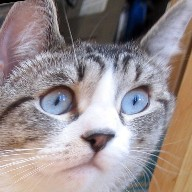

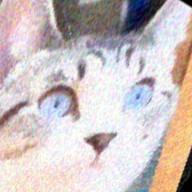

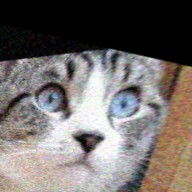

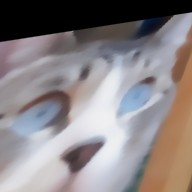

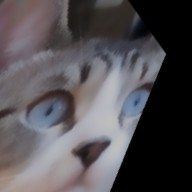

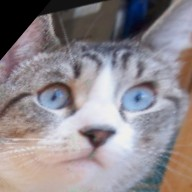

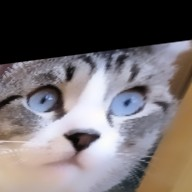

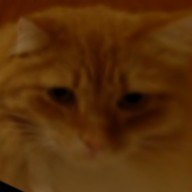

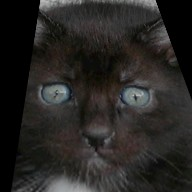

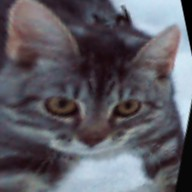

In [7]:
class CatIDDataset:
    def __init__(self, dataset, img_size=opt.img_size):
        self.img_size=img_size
        self.data = dataset
        self.par = None
        self.proc = self.Proc(img_size)
    
    def get_face(self, count):
        return self.data.batch(count)
    
    class Proc:
        def __init__(self, img_size):
            self.img_size = img_size
            self.Proc = ImgProc(self.img_size)
        
        def procFace(self, faceRaw):
            batch = self.Proc.procSingle(faceRaw, hsv=True, hsv_h=5, hsv_s=40, hsv_v=0.7, hsv_b=128, hsv_rate = 1)
            raw, landmarks, face = batch
    #         print(batch, face.landmarks)
            for i in range(9):
                pt = face.landmarks[i]
                noise = 0.1
                def rnd(x):
                    x += noise*random.random() - noise/2
                    return x
                face.landmarks[i] = [rnd(pt[0])*opt.img_size,rnd(pt[1])*opt.img_size]
            roi = face.perspective_roi(raw)
            return roi
        
        def __call__(self, rect):
            return self.procFace(rect)
    
    def batch(self, faces, augs):
        if self.par is None:
            usepar = in_notebook()
            self.par = util.Parallel(useThread = usepar)
        imgs = np.zeros((len(faces)*augs, self.img_size, self.img_size, 3), dtype=float)
        mappedFace = []
        for idx, face in enumerate(faces):
            face.useCacheAug = False
            for i in range(augs):
                mappedFace.append(face)
        rois = self.par.map(self.proc, mappedFace)
        for idx, roi in enumerate(rois):
            imgs[idx,:,:,:]=roi
            mappedFace[idx].useCacheAug = True
            
        return imgs

class CatIDModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.LeakyReLU(0.1, inplace=True)
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 7, stride=2, padding=3),
            self.bnorm(32),
            self.relu,
            nn.MaxPool2d(2),
            
            ResBlock(32, 64, stride=2),
            ResBlock(64, 64, stride=1),
            ResBlock(64, 128, stride=2),
            ResBlock(128, 128, stride=1),
            ResBlock(128, 128, stride=1),
            ResBlock(128, 128, stride=1),
            ResBlock(128, 256, stride=2),
        )
    def bnorm(self, ch):
        return nn.BatchNorm2d(ch)
    def forward(self, x):
        x = self.net(x)
        x = F.adaptive_avg_pool2d(x, (1,1))
        x = x.view(-1, x.shape[1])
        return x

class CatIDDist(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.LeakyReLU(0.2, True)
        self.feat = nn.Sequential(
#             ResBlock(128, 256, stride=1),
            ResBlock(512, 1024, stride=2),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.net = nn.Sequential(
            nn.Linear(1024, 512),
            self.relu,
            nn.Linear(512,2),
            nn.Softmax(1),
        )
    def forward(self, x, y):
#         x=self.feat(torch.cat((x, y), dim=1))
#         x=x.view(x.shape[0], -1)
#         return self.net(x)[:,0]
        return torch.sqrt(torch.sum(torch.pow(x-y, 2), dim=1))
def idDatasetTest(raw):
    data_id = CatIDDataset(raw)
    batch_size = 3
    face_ref = data_id.get_face(1)
    batch_ref = data_id.batch(face_ref, batch_size)
    print("AA",face_ref[0].landmarks)
    display.imshow(face_ref[0].perspective_roi(face_ref[0].imread()))
    batch_pos = data_id.batch(face_ref, batch_size)
    batch_neg = data_id.batch(data_id.get_face(batch_size), 1)
    def show(batch, count):
        for i in range(count):
            display.imshow(batch[i])
    show(batch_ref, batch_ref.shape[0])
    show(batch_pos, batch_ref.shape[0])
    show(batch_neg, batch_ref.shape[0])
    
if __name__ == "__main__" and opt.mode != "train" and in_notebook():
    print("test")
    idDatasetTest(data_dataset)

# Wrappers

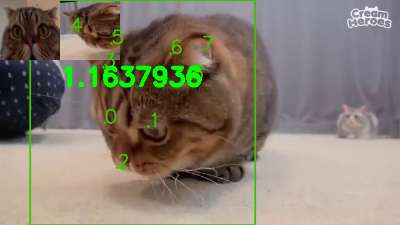

KeyboardInterrupt: 

In [18]:
class CatYoloDetector:
    def __init__(self, weights="yolo.weights", cfg='yolo.cfg', data='yolo.data', thresh=0.02, useMostProb=False):
        self.useMostProb = useMostProb
        self.weights = weights
        self.cfg = cfg
        self.data = data
        self.thresh = thresh
        self.margin = 1.35
        return
    
    def detect(self, img):
        faces = []
        imgh, imgw, _ = img.shape
        cv2.imwrite('temp.tmp.jpg', img)
        r = darknet.performDetect(imagePath="./temp.tmp.jpg", thresh=self.thresh, \
                                  configPath = self.cfg, weightPath = self.weights, \
                                  metaPath= self.data, showImage= False, \
                                  makeImageOnly = False, initOnly= False)
        def clamp(x, mini, maxi):
            return max(mini, min(maxi, x))
        for d in r:
            face = Cat()
            face.prob = d[1]
            face.ax = d[2][0] - d[2][2]*0.5
            face.ay = d[2][1] - d[2][3]*0.5
            face.aw = d[2][2]
            face.ah = d[2][3]
            face.rawPos = [face.ax,face.ay,face.aw,face.ah]
            #clip
            pt1 = [np.clip(face.ax,0,imgw-1), np.clip(face.ay,0,imgh-1)]
            pt2 = [np.clip(face.ax+face.aw,0,imgw-1), np.clip(face.ay+face.ah,0,imgh-1)]
            face.ax = int(pt1[0])
            face.ay = int(pt1[1])
            face.aw = abs(int(pt2[0]-pt1[0]))
            face.ah = abs(int(pt2[1]-pt1[1]))
            face.cx = int(face.ax + face.aw / 2)
            face.cy = int(face.ay + face.ah / 2)
            #sq clip
            face.aw = int(min(max(face.aw, face.ah)*self.margin, imgw, imgh))
            face.ah = face.aw
            face.cx = int(np.clip(face.cx, face.aw/2, imgw-face.aw/2-1))
            face.cy = int(np.clip(face.cy, face.aw/2, imgw-face.aw/2-1))
            face.ax = clamp(int(face.cx - face.aw/2), 0, imgw-1)
            face.ay = clamp(int(face.cy - face.ah/2), 0, imgh-1)
            faces.append(face)
#             print(imgh, imgw, face, d, pt1, pt2, face.ax, face.ay, face.aw, face.ah, face.cx, face.cy)
#             if abs(face.cx - d[2][0]) + abs(face.cy - d[2][1]) >5:
#                 raise Exception()
        if self.useMostProb:
            ret = []
            maxp = -1
            maxf = None
            for f in faces:
                if maxp<f.prob:
                    maxf = f
                    maxp = f.prob
            if not maxf is None:
                ret.append(maxf)
            faces = ret
        return faces

class CatLandmarkDetector:
    def __init__(self, modelpath='landmark.model'):
        self.path = modelpath
        self.model = LandmarkModel()
        self.model_old = torch.load(self.path)
        self.model.load_state_dict(self.model_old.state_dict())
        self.model.eval()
        self.model.cuda()
    
    def detect(self, img, faces):
        for face in faces:
            roi = face.roi(img)
#             print(roi.shape, face.ax, face.ay, face.aw, face.ah, face.prob, face.rawPos)
            roi = cv2.resize(roi, dsize=(opt.img_size, opt.img_size))
            t = Tensor(roi)
            t = t.view(1, opt.img_size, opt.img_size, 3)
            t = t.permute(0, 3, 1, 2)
            t = (t.float() - 127.5)/127.5
            track = self.model(t)
            track = track.data.cpu().numpy()
#             track = np.clip(img, -1, 2)
            landmarks = []
            for i in range(9):
                x=track[0][2*i]
                y=track[0][2*i+1]
                landmarks.append([x*face.aw + face.ax, y*face.ah + face.ay])
            face.landmarks = landmarks
        return faces

class kData:
    def __init__(self):
        self.dots = []
        self.centers = []
class kDatum:
    def __init__(self):
        self.cls=0
        self.vec=[0]
        self.is_center=False
class kNN:
    pass
class kMeans:
    pass

class CatRecognizor:
    def __init__(self, path = 'id.model', pathdist = 'iddist.model'):
#         self.model = torch.load(path)
        self.model = CatIDModel()
        self.model_old = torch.load(path)
        self.model.load_state_dict(self.model_old.state_dict())
        self.model.eval()
        self.model.cuda()
#         self.modelDist = torch.load(pathdist)
        self.modelDist = CatIDDist()
#         self.model_old = torch.load(pathdist)
#         self.modelDist.load_state_dict(self.model_old.state_dict())
        self.modelDist.eval()
        self.modelDist.cuda()
    
    def procImg(self, nd):
        t = Tensor(nd)
        t = t.view(1, t.shape[0], t.shape[1], t.shape[2])
        t = t.permute(0, 3, 1, 2)
        t = (t.float() - 127.5)/127.5
        return t
    
    def dist(self, a, b):
        a = Tensor(a)
        b = Tensor(b)
        vec = self.modelDist(a,b)
        print(vec.shape, vec)
        return vec[0].view(-1).detach().cpu().numpy()
    
    def detect(self, frame, faces):
        ret = []
        for face in faces:
            img = face.perspective_roi(frame)
            vec = self.model(self.procImg(img))
            vec = vec.detach().cpu().numpy()
            face.vec=vec
            ret.append(face)
        return ret

def id_vid_test(vidpath = "dun.mp4", ref="cat.jpg", thresh=0.5):
    cap = cv2.VideoCapture(vidpath)
    yolo = CatYoloDetector()
    yolo.useMostProb = True
    land = CatLandmarkDetector()
    recog = CatRecognizor(path='id.model')
    
    img = cv2.imread(ref)
    faces = yolo.detect(img)
    if len(faces) < 1:
        print("no face in reference!")
        return
    faces = land.detect(img, faces)
    ref_face = cv2.medianBlur(img, 1+2*2)
    faces = recog.detect(img, faces)
    ref_face = faces[0]
    ref_face_roi = ref_face.perspective_roi(img)
    print(recog.dist(ref_face.vec, ref_face.vec))
    i = input()
    if i =='0':
        return
    
    time_frame=0
    frame_skip = 7
    while(cap.isOpened()):
        for i in range(frame_skip):
            ret, frame = cap.read()
        
        roi_size = int(frame.shape[1] * 0.15)
        faces = yolo.detect(frame)
        faces = land.detect(frame, faces)
        faces = recog.detect(frame, faces)
        
        for f in faces:
            flat = f.perspective_roi(frame)
            frame[0:roi_size, roi_size:roi_size*2, :] = cv2.resize(flat,dsize=(roi_size, roi_size))
            f.draw(frame, thickness=int(max(1, frame.shape[1]/300)))
#             diff = f.vec - ref_face.vec
#             diff = np.mean(np.sqrt(np.sum(np.power(diff, 2), 0)))
            diff = recog.dist(f.vec, ref_face.vec)[0]
            if(diff < thresh):
                color = (0,255,0)
            else :
                color = (255,0,255)
            cv2.putText(frame, str(diff), (roi_size, int(roi_size+30*frame.shape[1]/480)), 0, frame.shape[1]/480, color, int(2*frame.shape[1]/240))
#             print(diff)
        flat = ref_face_roi
        frame[0:roi_size, 0:roi_size, :]=cv2.resize(flat, dsize=(roi_size, roi_size))
        
        display.vidshow(frame, maxSize=(400,5000))
        time.sleep(max(0.001, (1/(24/frame_skip))-(time.time()-time_frame)-0.55))
        time_frame=time.time()
    cap.release()

if __name__ == "__main__" and opt.mode != "train" and opt.target == "id":
    id_vid_test(vidpath = "lulu.mp4",  ref="lulu.jpg", thresh = 1.45)

## runtime

In [9]:
def landmark_perspective():
    landmark = CatLandmarkDetector('landmark.model')
    for i in range(16):
        img, b_land = data.batch(1)
        img = img[0]
        face = Cat(None)
        face.ax = face.ay = 0
        face.aw = face.ah = opt.img_size
        landmark.detect(img, [face])
#         face.draw(img)
        display.imshow(img)
        roi = face.perspective_roi(img)
        display.imshow(roi)
        print("wa", face.landmarks)

def landmark_test():
    landmark = CatLandmarkDetector('landmark.model')
    data.mt = False
    for i in range(16):
        img, b_land = data.batch(1)
        img = img[0]
        face = Cat(None)
        face.ax = face.ay = 0
        face.aw = face.ah = opt.img_size
        landmark.detect(img, [face])
        face.draw(img)
        display.imshow(img)
        print("wa", face.landmarks)

def landmark_vid_test(vidpath = 'lulu.mp4'):
    cap = cv2.VideoCapture(vidpath)
    yolo = CatYoloDetector()
    yolo.useMostProb = True
    land = CatLandmarkDetector()
    t=0
    while(cap.isOpened()):
        ret, frame = cap.read()
        ret, frame = cap.read()
        ret, frame = cap.read()
        logger.print("detecting", flush=False)
        faces = yolo.detect(frame)
        logger.print("marking", flush=False)
        faces = land.detect(frame, faces)
        logger.print("drawing", flush=False)
        for f in faces:
#             print(f.landmarks, f.ax, f.ay, f.aw, f.ah, f.prob)
            flat = f.perspective_roi(frame)
            frame[0:flat.shape[0], 0:flat.shape[1], :] = flat
            f.draw(frame, thickness=int(max(1, frame.shape[1]/300)))
        display.vidshow(frame, maxSize=(640,111111))
        time.sleep(max(0.001, (1/8)-(time.time()-t)))
        t=time.time()
    cap.release()

# Runtime

In [10]:
if __name__=="__main__":
    logger = Logger()
    logger.print("inited")
    data_raw = Dataset()
    logger.print("raw loaded")
    data = LandmarkDataset(data_raw, img_size=opt.img_size)
    logger.print("landmark loaded")
    data_id = CatIDDataset(data_raw)
    logger.print("id loaded")

[0:00:00] inited
searching
9997 searched
[0:00:05.233192] raw loaded
[0:00:05.234193] landmark loaded
[0:00:05.235193] id loaded


## id trainer

In [11]:
if __name__ == "__main__" and opt.mode == "train" and opt.target == "id":
    batch_size = opt.batch_size
    if opt.load:
        #load model or optim
        logger.print("loading")
        model = torch.load('id.model')
        modelDist = torch.load('iddist.model')
    else:
        logger.print("new model")
        modelDist = CatIDDist()
        model = CatIDModel()
    modelDist.train()
    model.train()
    optim = torch.optim.Adam(chain(model.parameters(), modelDist.parameters()), lr = opt.lr, amsgrad = True)
    model.cuda()
    modelDist.cuda()
    
    logger.logdir = os.path.join(r'F:\Library\kitty\temp_id', getTimeStamp())
    train_step = 0
    if opt.load:
        #load step/logdir
        pass
    def batch(batch_size):
        face_ref = data_id.get_face(1)
        batch_ref = imgproc(data_id.batch(face_ref, batch_size))
        batch_pos = imgproc(data_id.batch(face_ref, batch_size))
        batch_neg = imgproc(data_id.batch(data_id.get_face(batch_size), 1))
        batch_neg2 = imgproc(data_id.batch(data_id.get_face(batch_size), 1))
        return batch_ref, batch_pos, batch_neg, batch_neg2
    def dist(a, b):
        #reduce mean
        return modelDist(a,b)
#         return torch.sqrt(torch.sum((a-b)**2, 1))
    time_save = 0
    batch_thread = util.ThreadBuffer()
    while True:
        logger.print("batch")
        batch_ref, batch_pos, batch_neg, batch_neg2 = batch_thread.get(batch, [batch_size])
        logger.print("fin")
        
        ref=model(batch_ref)
        pos=model(batch_pos)
        neg=model(batch_neg)
        neg2=model(batch_neg2)
        
        dist_pos = dist(ref,pos)
        dist_neg = dist(ref,neg)
        dist_negs = dist(neg,neg2)
        logger.print(dist_pos.shape, dist_neg.shape)
#         margin = torch.max(Tensor([0.6]), torch.mean(dist_neg**2 - dist_pos ** 2))
#         margin = torch.mean(dist_neg**2 - dist_pos ** 2)
        margin = 1
        loss = torch.max(Tensor([0.0]), (dist_pos - dist_neg + margin)**2)
#         loss2 = torch.max(Tensor([0.0]), dist_pos ** 2 - dist_negs ** 2 + 0.5 * margin)
#         loss = loss + loss2
        loss = torch.sum(loss)
        
#         print(train_step, loss, torch.mean(dist_pos), torch.mean(dist_neg), torch.mean(dist_negs), torch.min(dist_negs), margin, torch.sum(dist_pos))
        logger.log({"loss/loss":loss.data, 
                    "dist/mean dist pose":torch.mean(dist_pos).data, 
                    "dist/mean dist neg":torch.mean(dist_neg).data, 
                    "dist/mean dist negs":torch.mean(dist_negs).data, 
                    "dist/min dist negs":torch.min(dist_negs).data, 
#                     "dist/margin":margin.data, 
                    "dist/sum dist pose":torch.sum(dist_pos).data}, global_step = train_step)
        if time.time() - time_save > 30:
            logger.print("saving")
            with open("id.model", 'wb') as f:
                torch.save(model, f)
            with open("iddist.model", 'wb') as f:
                torch.save(modelDist, f)
            time_save = time.time()
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_step += 1

## landmark trainer

In [12]:
if __name__ == "__main__" and opt.mode == "train" and opt.target == "landmark":
    batch_size = opt.batch_size
    if opt.load:
        print("loading")
        state = torch.load('landmark.state')
        model = state['model']
    else:
        model = LandmarkModel()
    model.train()
    optim = torch.optim.Adam(model.parameters(), lr=opt.lr, amsgrad=True)
    model.cuda()
    
    logger.logdir = os.path.join(r"F:\Library\kitty\temp", getTimeStamp())
    train_step = 0
    if opt.load:
        logger.logdir = state['logdir']
        train_step = state['train_step']
        del state
    def batch(batch_size):
        t = time.time()
        batch_img, batch_label = data.batch(batch_size)
#         print(time.time()-t)
        batch_img = imgproc(batch_img)
        batch_label = Tensor(batch_label)
        return batch_img, batch_label
    batch_thread = util.ThreadBuffer()
    time_log = 0
    time_img = 0
    time_save = 0
    time_dbatch = 0
    while True:
        t = time.time()
        batch_img, batch_label = batch_thread.get(batch, [opt.batch_size])
        time_dbatch = time.time() - t
        
        tracked = model(batch_img)
        loss = torch.mean(torch.pow(tracked - batch_label, 2))
        optim.zero_grad()
#         nn.utils.clip_grad_norm(model.parameters(), 1)
        loss.backward()
        optim.step()
        
        if time.time() - time_log > 1:
            logger.log({"loss":loss.data, "time_batch":time_dbatch}, global_step = train_step)
            time_log = time.time()
        if time.time() - time_save > 180:
            if time_save == 0:
                time_save = time.time()
            else:
                logger.print("saving...")
                with open("landmark.model", 'wb') as f:
                    torch.save(model, f)
                with open("landmark.state", 'wb') as f:
                    torch.save({"model":model, "train_step":train_step, "logdir":logger.logdir}, f)
                logger.print("saved!")
                time_save = time.time()
        train_step += 1

## tests

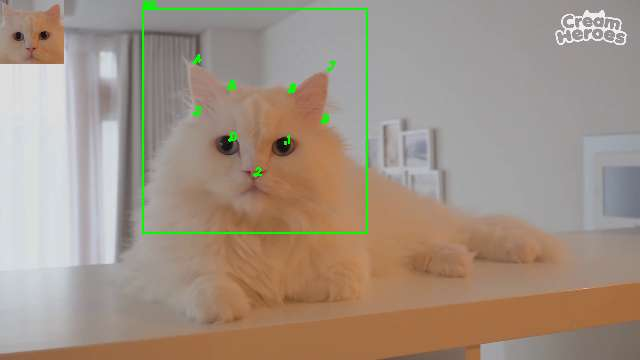

[0:00:45.727343] detecting


KeyboardInterrupt: 

In [13]:
if __name__ == "__main__" and opt.mode != 'train':
    print("bi")
#     dataset_main()
#     lulu()
#     dataset_bench()
#     landmark_test()
    landmark_vid_test("dun.mp4")
#     landmark_perspective()
    id_folder_test()
    print("da")

In [ ]:
if __name__ == "__main__" and opt.mode != "train":
    state = torch.load('landmark.state')
    model = state['model']
    with open("landmark.model", 'wb') as f:
        torch.save(model, f)
    print("saved")

In [ ]:
if __name__ == "__main__" and opt.mode != "train":
    data = torch.randn(5,3)
    print(data)
    print(F.softmax(data, dim=1))
    print(F.softmax(data, dim=1).sum())  # 확률 분포이기 때문에 합이 1 입니다!
    print(F.log_softmax(data, dim=0))  # log_softmax 도 있습니다.

In [19]:
if __name__=="__main__" and in_notebook():
    !ipython nbconvert --to python dataset.ipynb

[TerminalIPythonApp] WARNING | Subcommand `ipython nbconvert` is deprecated and will be removed in future versions.
[TerminalIPythonApp] WARNING | You likely want to use `jupyter nbconvert` in the future
[NbConvertApp] Converting notebook dataset.ipynb to python
[NbConvertApp] Writing 43070 bytes to dataset.py
